In [1]:
import torch
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as  stats

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=";")

In [3]:
data = data[data['total sulfur dioxide']  <200]
columnsToZscore = data.keys()
columnsToZscore = columnsToZscore.drop('quality')
data[columnsToZscore] = data[columnsToZscore].apply(stats.zscore)
data['boolQuality'] = 0

data['boolQuality'] [data['quality'] > 5] = 1

data[['quality','boolQuality']]

C:\Users\M-Ali\AppData\Local\Temp\ipykernel_8452\1973829820.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'] [data['quality'] > 5] = 1


,quality,boolQuality
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0
...,...,...
1594,5,0
1595,6,1
1596,6,1
1597,5,0


In [4]:
dataT = torch.tensor(data[columnsToZscore].values).float()
labelsT = torch.tensor(data['boolQuality'].values).float()
labels = labelsT[:,None]

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(dataT,labels,test_size=0.2)

trainData = TensorDataset(train_data,train_labels)
testData = TensorDataset(test_data,test_labels)

batchsize = 32

train_loader = DataLoader(trainData,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(testData,batch_size=trainData.tensors[0].shape[0])

In [8]:
class AllWine(nn.Module):
    def __init__(self,actfun):
        super().__init__()
        self.input = nn.Linear(11,16)

        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)

        self.output = nn.Linear(32, 1)
        self.actfun = actfun
    def forward(self,x):
        actfun = getattr(torch.nn,self.actfun)
        x = actfun()(self.input(x))
        x = actfun()(self.fc1((x)))
        x = actfun()(self.fc2(x))
        return self.output(x)
        

In [9]:
net = AllWine("ReLU")
net(torch.randn(10,11)).shape

torch.Size([10, 1])

In [10]:
NumEpochs = 1000
def trainTheModel():
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(wineNet.parameters(),lr = .01)

    losses = torch.zeros(NumEpochs)
    trainAcc = []
    testAcc = []

    for epoch in range(NumEpochs):
        wineNet.train()

        batchAcc = []
        batchLoss = []

        for X,y in train_loader:
            yhat = wineNet(X)
            loss = lossfun(yhat,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean(((yhat > 0) == y).float()).item())
            
        trainAcc.append(np.mean(batchAcc))
        losses[epoch]= np.mean(batchLoss)


        wineNet.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yhat = wineNet(X)
        testAcc.append(100 * torch.mean(((yhat > 0) == y).float()).item())
    return trainAcc,testAcc, losses

In [11]:
activation_funs = ["ReLU", "ReLU6", 'LeakyReLU']

trainaccbyact = np.zeros((NumEpochs,len(activation_funs)))
testaccbyact = np.zeros((NumEpochs,len(activation_funs)))

for ai, actfun in enumerate(activation_funs):
    wineNet = AllWine(actfun)
    trainaccbyact [:,ai],testaccbyact[:,ai],losses = trainTheModel()

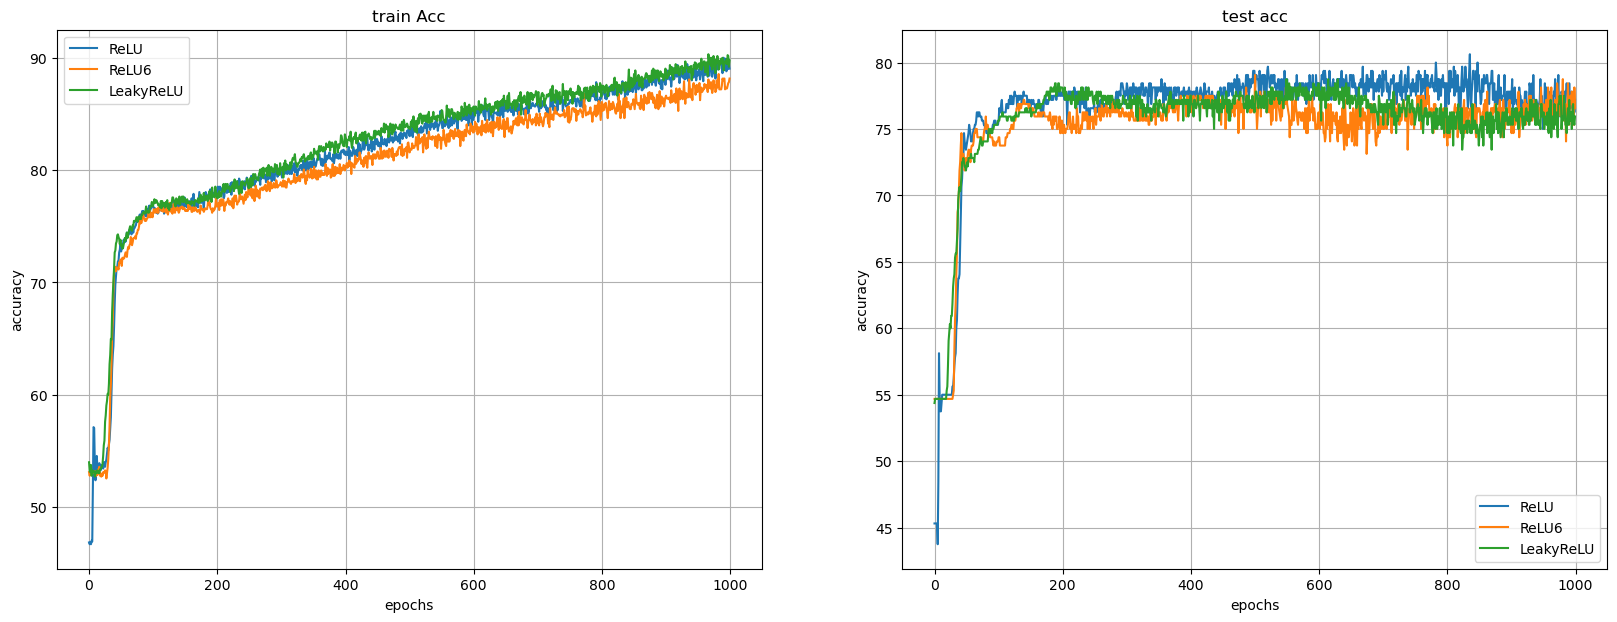

In [12]:
fig,axs = plt.subplots(1,2,figsize= (20,7))

axs[0].plot(trainaccbyact)
axs[0].set_title("train Acc")
axs[1].plot(testaccbyact)
axs[1].set_title("test acc")

for i in range(2):
    axs[i].legend(activation_funs)
    axs[i].set_xlabel("epochs")
    axs[i].set_ylabel("accuracy")
    axs[i].grid()
plt.show()